Degree centrality
CS_CSIZ Ttest_indResult(statistic=2.0511917862908935, pvalue=0.04083790344316652)


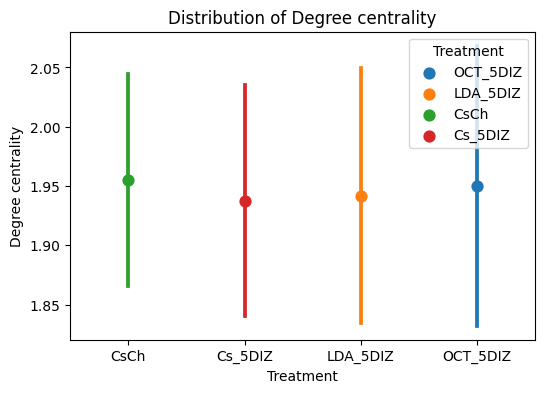

In-Strength distribution, w=count
CS_CSIZ Ttest_indResult(statistic=3.985179805655954, pvalue=7.769568418174595e-05)
CS_OCT Ttest_indResult(statistic=-4.423739300029809, pvalue=1.4266424452819262e-05)


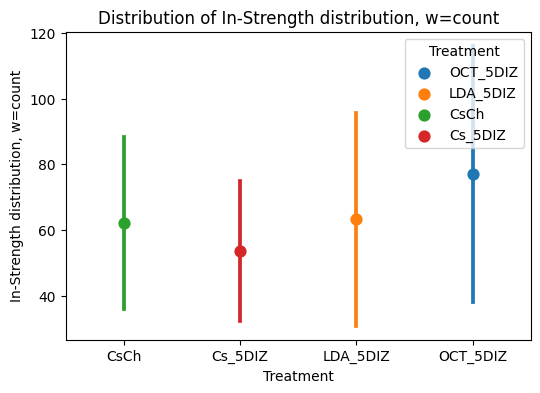

Out-Strength distribution, w=count
CS_CSIZ Ttest_indResult(statistic=3.9616599773182273, pvalue=8.548684958724143e-05)
CS_OCT Ttest_indResult(statistic=-4.31573152230111, pvalue=2.261785237884138e-05)


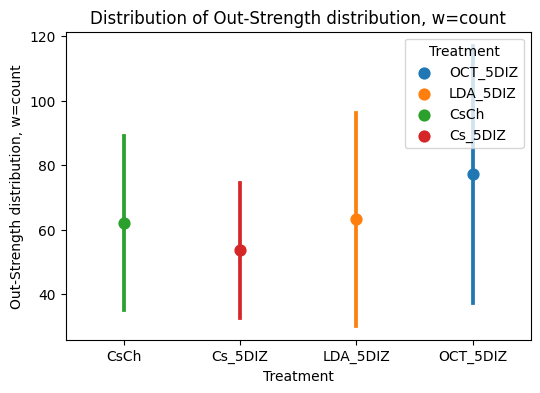

In-Strength distribution, w=duration
CS_LDA Ttest_indResult(statistic=-2.0377050256996423, pvalue=0.042078757734231934)
CS_OCT Ttest_indResult(statistic=-5.541016742854451, pvalue=1.0033561450205924e-07)


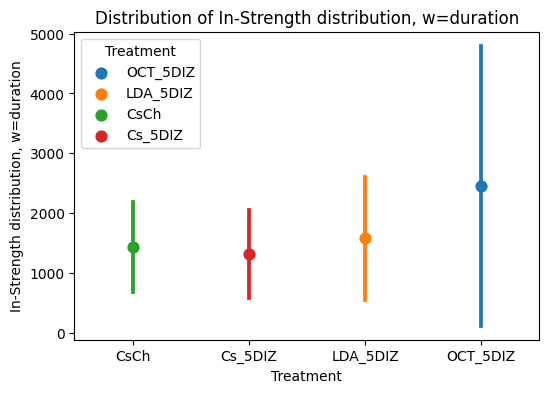

Out-Strength distribution, w=duration
CS_LDA Ttest_indResult(statistic=-2.012172574045363, pvalue=0.04471424735300062)
CS_OCT Ttest_indResult(statistic=-5.508573570524307, pvalue=1.177323307407406e-07)


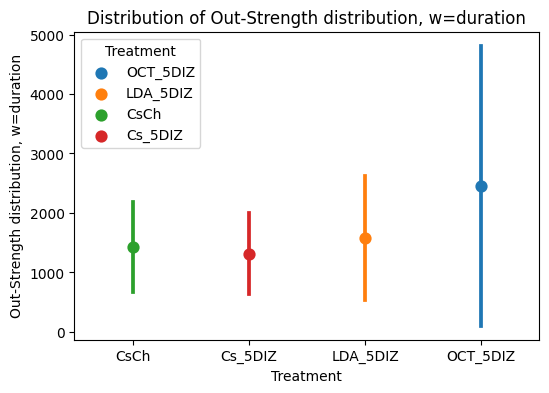

Weighted Degree (count)
CS_CSIZ Ttest_indResult(statistic=4.136244571261005, pvalue=4.154389406749844e-05)
CS_OCT Ttest_indResult(statistic=-4.4712927328509595, pvalue=1.16664652805712e-05)


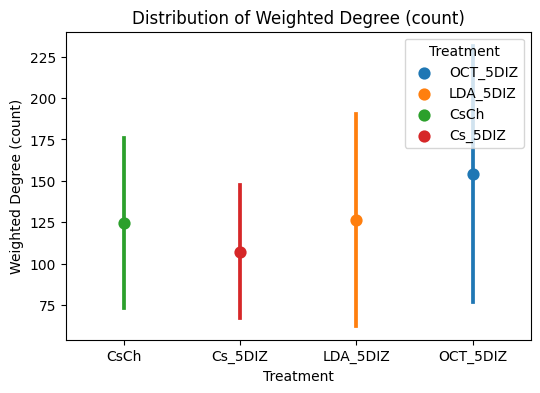

Weighted Degree (duration)
CS_LDA Ttest_indResult(statistic=-2.069765117334818, pvalue=0.03896577985853686)
CS_OCT Ttest_indResult(statistic=-5.574446508346781, pvalue=8.562062095712082e-08)


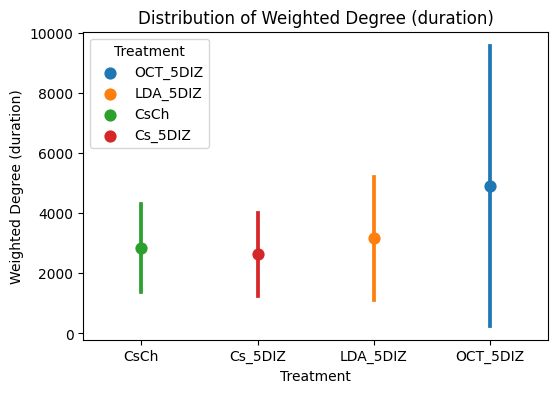

Betweenness centrality w=None
CS_CSIZ Ttest_indResult(statistic=-2.86738654558653, pvalue=0.004319737094905281)
CS_LDA Ttest_indResult(statistic=-1.987683774483237, pvalue=0.047341516772851394)


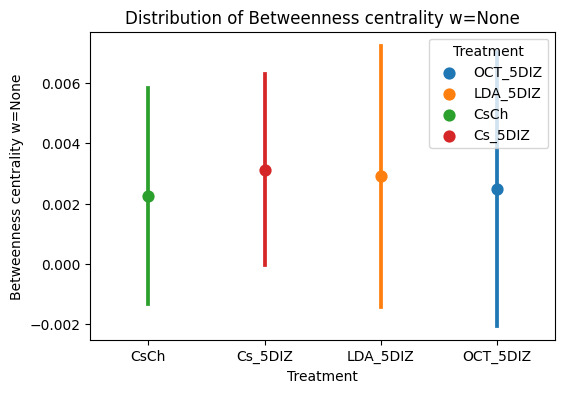

Clustering coefficient w=None
CS_CSIZ Ttest_indResult(statistic=2.5888606171866133, pvalue=0.009915784762505438)


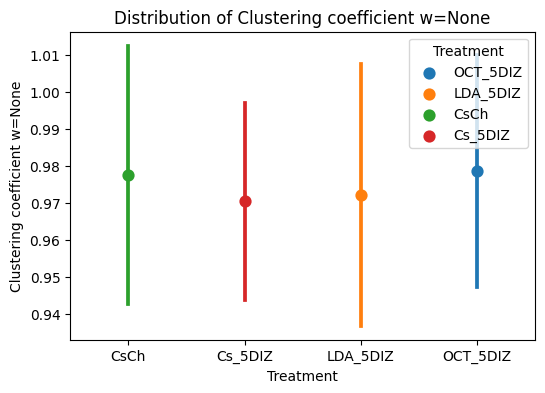

Clustering coefficient w=count
CS_CSIZ Ttest_indResult(statistic=7.604500243307545, pvalue=1.4975938333256508e-13)
CS_LDA Ttest_indResult(statistic=7.916010602112856, pvalue=1.3363499388184364e-14)
CS_OCT Ttest_indResult(statistic=3.9691715620135963, pvalue=8.835808073915245e-05)


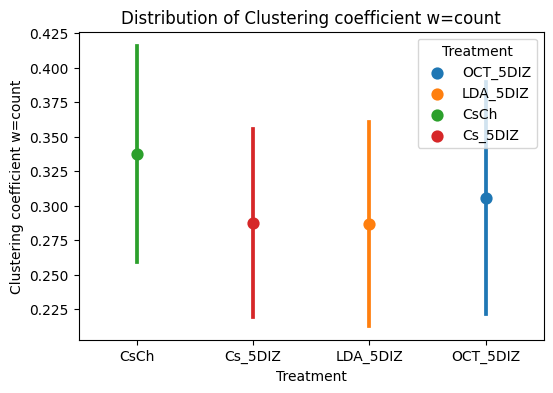

Clustering coefficient w=duration
CS_CSIZ Ttest_indResult(statistic=5.085784139342322, pvalue=5.224640022678099e-07)
CS_LDA Ttest_indResult(statistic=8.130501965095817, pvalue=3.3678202039335878e-15)
CS_OCT Ttest_indResult(statistic=4.577535154036849, pvalue=6.524392405865939e-06)


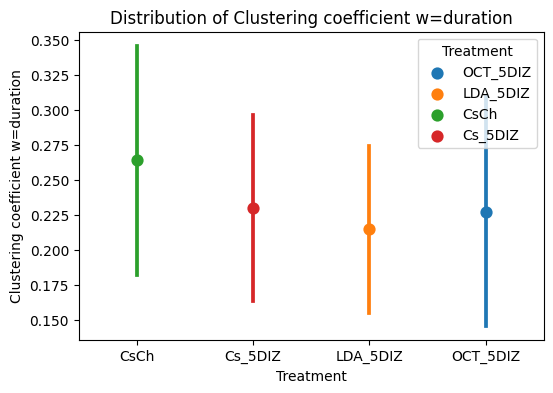

In [2]:
import os
import toml
import scipy
import pandas as pd
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)  
INPUT_PATH = os.path.join(settings.RESULTS_DIR, "local_measures")
all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = pd.DataFrame()
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)

    for group_name, group_path in all_groups.items():
        df = pd.read_csv(group_path, index_col=0)
        df.rename_axis("Fly")
        df['Treatment'] = treatment_name
        df['Group'] = group_name.replace(".csv", "")
        treatment_dataframes = pd.concat([treatment_dataframes, df])

treatment_dataframes = treatment_dataframes.set_index('Treatment', append=True)
treatment_dataframes = treatment_dataframes.set_index('Group',append=True)

combined_data_reset = treatment_dataframes.reset_index()

order = ["CsCh", "Cs_5DIZ", "LDA_5DIZ", "OCT_5DIZ"] 
for measure_name in treatment_dataframes.columns:
    sum_CsCh = combined_data_reset[combined_data_reset['Treatment']=='CsCh']
    sum_Cs_5DIZ = combined_data_reset[combined_data_reset['Treatment']=='Cs_5DIZ']
    sum_LDA_5DIZ = combined_data_reset[combined_data_reset['Treatment']=='LDA_5DIZ']
    sum_OCT_5DIZ = combined_data_reset[combined_data_reset['Treatment']=='OCT_5DIZ']
    sum_LDA_OCT_5DIZ = combined_data_reset[combined_data_reset['Treatment']=='LDA_OCT_5DIZ']


    CS_CSIZ = scipy.stats.ttest_ind(sum_CsCh[measure_name], sum_Cs_5DIZ[measure_name], equal_var=False)
    CS_LDA = scipy.stats.ttest_ind(sum_CsCh[measure_name], sum_LDA_5DIZ[measure_name], equal_var=False)
    CS_OCT = scipy.stats.ttest_ind(sum_CsCh[measure_name], sum_OCT_5DIZ[measure_name], equal_var=False)

    if CS_CSIZ.pvalue < 0.05 or CS_LDA.pvalue < 0.05 or CS_OCT.pvalue < 0.05:
        print(measure_name)
        if CS_CSIZ.pvalue < 0.05:
            print(f'CS_CSIZ {CS_CSIZ}')

        if CS_LDA.pvalue < 0.05:
            print(f'CS_LDA {CS_LDA}')

        if CS_OCT.pvalue < 0.05:
            print(f'CS_OCT {CS_OCT}')

        plt.figure(figsize=(6, 4))
        sns.pointplot(data=combined_data_reset, x="Treatment", y=measure_name, hue='Treatment',errorbar='sd', order=order)
        plt.xlabel("Treatment")
        plt.ylabel(measure_name)
        plt.title(f'Distribution of {measure_name}')
        plt.show()

        print("="*100)
